In [6]:
import numpy as np
import cv2
import timm
import tqdm

import torch
from torchvision import datasets, transforms
from torch.utils import data

from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt


np.random.seed(42)
NUM_CLASSES = 9
BATCH_SIZE = 32
device = torch.device("cuda")
PATH_TO_TEST_DATASET = "data/CRC-VAL-HE-7K/"


def cv2_loader(path: str):
    return Image.fromarray(cv2.imread(path, -1)[:, :, ::-1])


def cv2_huen10_damage_loader(path: str):
    img = cv2.imread(path, -1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = np.int32(img)
    img[:, :, 0] -= 10
    img = np.uint8(np.clip(img, 0, 255))
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return Image.fromarray(img[:, :, ::-1])


def cv2_hue10_damage_loader(path: str):
    img = cv2.imread(path, -1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = np.int32(img)
    img[:, :, 0] += 10
    img = np.uint8(np.clip(img, 0, 255))
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return Image.fromarray(img[:, :, ::-1])

def cv2_huen20_damage_loader(path: str):
    img = cv2.imread(path, -1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = np.int32(img)
    img[:, :, 0] -= 20
    img = np.uint8(np.clip(img, 0, 255))
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return Image.fromarray(img[:, :, ::-1])


def cv2_hue20_damage_loader(path: str):
    img = cv2.imread(path, -1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = np.int32(img)
    img[:, :, 0] += 20
    img = np.uint8(np.clip(img, 0, 255))
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return Image.fromarray(img[:, :, ::-1])


In [7]:
model = timm.create_model('efficientnet_b0.ra_in1k', pretrained=True, num_classes=NUM_CLASSES, in_chans=3, global_pool='avg')
model.load_state_dict(torch.load('./0.9774_0.9688.pt'))
model.to(device)
model.eval()

model2 = timm.create_model('efficientnet_b0.ra_in1k', pretrained=True, num_classes=NUM_CLASSES, in_chans=3, global_pool='max')
model2.load_state_dict(torch.load('./97_39_96_20.pt'))
model2.to(device)
model2.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [8]:
def evaluate(model, test_dataloader):
    print("Running Evaluation...")

    targets_array = []
    predictions_array = []

    with torch.no_grad():

        test_iter = iter(test_dataloader)
        for j in tqdm.tqdm(range(len(test_dataloader))):

            image, labels = next(test_iter)
            image = image.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)


            predictions = model(image)
            predictions2 = model2(image)
            
            _, predictions = torch.max(predictions.data + predictions2.data, 1)

            predictions = predictions.detach().cpu().numpy()
            targets = labels.detach().cpu().numpy()

            for k in range(targets.shape[0]):

                target = targets[k]
                predicted = predictions[k]

                targets_array.append(target)
                predictions_array.append(predicted)

        print("Accuracy: " + str(accuracy_score(targets_array, predictions_array)))
        print("Balanced Accuracy: " + str(balanced_accuracy_score(targets_array, predictions_array)))
        

        print(classification_report(targets_array, predictions_array))
        print(confusion_matrix(targets_array, predictions_array))
        
        
        return predictions_array

In [9]:
test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=test_transforms, loader=cv2_loader)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=False, drop_last=False)

predictions_no_hue_aug = evaluate(model, test_dataloader)

Running Evaluation...


100%|████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:16<00:00, 13.68it/s]

Accuracy: 0.9807799442896936
Balanced Accuracy: 0.9709035992478512
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1338
           1       1.00      1.00      1.00       847
           2       0.98      0.99      0.99       339
           3       0.98      1.00      0.99       634
           4       0.99      1.00      0.99      1035
           5       0.90      0.97      0.93       592
           6       0.99      0.98      0.98       741
           7       0.96      0.81      0.88       421
           8       0.99      0.99      0.99      1233

    accuracy                           0.98      7180
   macro avg       0.98      0.97      0.97      7180
weighted avg       0.98      0.98      0.98      7180

[[1333    1    0    0    3    1    0    0    0]
 [   0  847    0    0    0    0    0    0    0]
 [   0    0  337    0    0    1    0    1    0]
 [   0    0    0  634    0    0    0    0    0]
 [   3    0    0    0 1031    0    0

In [10]:
test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=test_transforms, loader=cv2_huen10_damage_loader)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=False, drop_last=False)

predictions_huen10_aug = evaluate(model, test_dataloader)

Running Evaluation...


100%|████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:16<00:00, 14.01it/s]

Accuracy: 0.979108635097493
Balanced Accuracy: 0.9677944965984023
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1338
           1       1.00      1.00      1.00       847
           2       0.99      0.99      0.99       339
           3       0.98      1.00      0.99       634
           4       0.99      1.00      0.99      1035
           5       0.87      0.98      0.92       592
           6       0.99      0.98      0.99       741
           7       0.95      0.78      0.86       421
           8       0.99      0.99      0.99      1233

    accuracy                           0.98      7180
   macro avg       0.97      0.97      0.97      7180
weighted avg       0.98      0.98      0.98      7180

[[1329    1    0    0    3    5    0    0    0]
 [   0  847    0    0    0    0    0    0    0]
 [   0    0  337    0    0    0    0    2    0]
 [   0    0    0  633    0    0    0    1    0]
 [   2    0    0    0 1032    0    0 

In [11]:
test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=test_transforms, loader=cv2_hue10_damage_loader)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=False, drop_last=False)

predictions_hue10_aug = evaluate(model, test_dataloader)

Running Evaluation...


100%|████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:16<00:00, 13.57it/s]

Accuracy: 0.9788300835654596
Balanced Accuracy: 0.968268597130275
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1338
           1       1.00      1.00      1.00       847
           2       0.98      1.00      0.99       339
           3       0.98      1.00      0.99       634
           4       0.98      0.99      0.99      1035
           5       0.89      0.98      0.93       592
           6       0.99      0.98      0.98       741
           7       0.96      0.79      0.86       421
           8       0.99      0.98      0.99      1233

    accuracy                           0.98      7180
   macro avg       0.97      0.97      0.97      7180
weighted avg       0.98      0.98      0.98      7180

[[1333    1    0    0    3    1    0    0    0]
 [   0  847    0    0    0    0    0    0    0]
 [   0    0  338    0    1    0    0    0    0]
 [   0    0    0  634    0    0    0    0    0]
 [   4    2    0    0 1028    0    0 

In [12]:
test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=test_transforms, loader=cv2_huen20_damage_loader)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=False, drop_last=False)

predictions_huen20_aug = evaluate(model, test_dataloader)

Running Evaluation...


100%|████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:16<00:00, 13.91it/s]

Accuracy: 0.966991643454039
Balanced Accuracy: 0.9498794655299859
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1338
           1       0.99      1.00      1.00       847
           2       0.94      0.98      0.96       339
           3       0.97      1.00      0.98       634
           4       0.98      1.00      0.99      1035
           5       0.81      0.97      0.88       592
           6       0.99      0.98      0.98       741
           7       0.94      0.67      0.78       421
           8       0.99      0.97      0.98      1233

    accuracy                           0.97      7180
   macro avg       0.96      0.95      0.95      7180
weighted avg       0.97      0.97      0.97      7180

[[1319    1    0    0   13    5    0    0    0]
 [   0  847    0    0    0    0    0    0    0]
 [   0    4  331    3    0    0    0    1    0]
 [   0    0    0  633    0    0    0    1    0]
 [   0    1    0    0 1034    0    0 

In [13]:
test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=test_transforms, loader=cv2_hue20_damage_loader)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=False, drop_last=False)

predictions_hue20_aug = evaluate(model, test_dataloader)

Running Evaluation...


100%|████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:16<00:00, 13.94it/s]

Accuracy: 0.9715877437325905
Balanced Accuracy: 0.959927462577054
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1338
           1       0.99      1.00      0.99       847
           2       0.95      1.00      0.98       339
           3       0.96      1.00      0.98       634
           4       0.98      0.99      0.98      1035
           5       0.88      0.95      0.92       592
           6       0.98      0.99      0.98       741
           7       0.91      0.76      0.83       421
           8       0.99      0.97      0.98      1233

    accuracy                           0.97      7180
   macro avg       0.96      0.96      0.96      7180
weighted avg       0.97      0.97      0.97      7180

[[1333    1    0    0    4    0    0    0    0]
 [   0  847    0    0    0    0    0    0    0]
 [   0    0  338    0    1    0    0    0    0]
 [   0    0    1  633    0    0    0    0    0]
 [   4    8    0    0 1022    0    0 

In [14]:
test_vis_huen20_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=None, loader=cv2_huen20_damage_loader)
test_vis_hue20_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=None, loader=cv2_hue20_damage_loader)
test_vis_no_hue_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=None, loader=cv2_loader)

In [15]:
def plot_pair(title, imgs, texts):
    fig, axes = plt.subplots(nrows=1, ncols=3)
    fig.suptitle(title)
    for img, text, ax in zip(imgs, texts, axes.ravel()):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(text)
    fig.tight_layout()

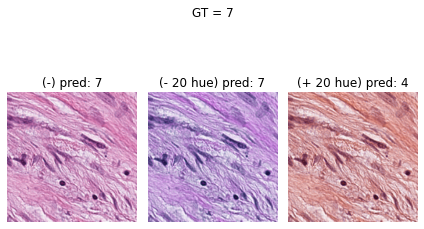

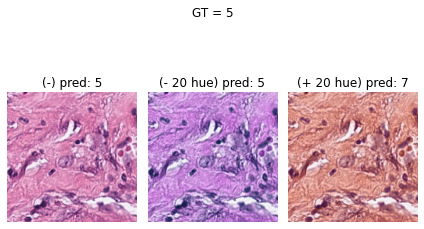

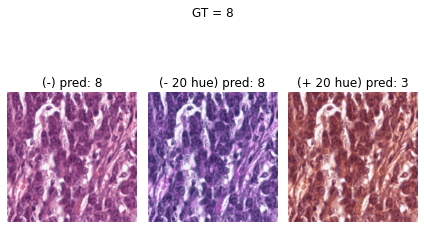

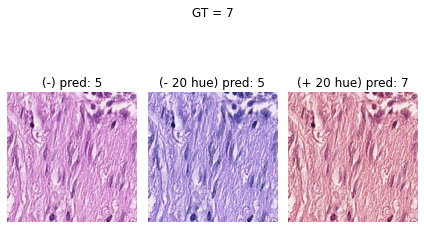

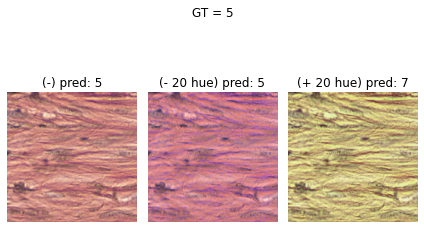

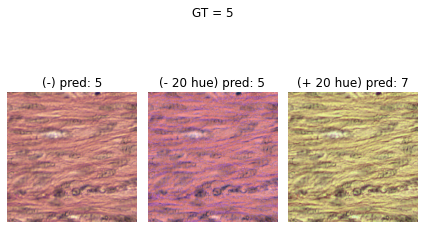

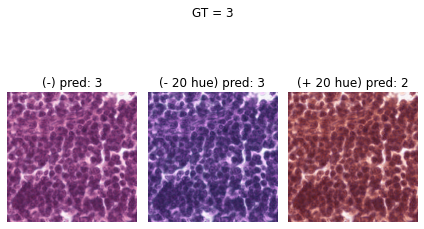

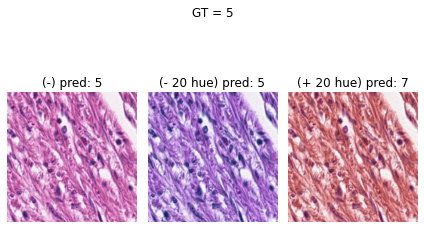

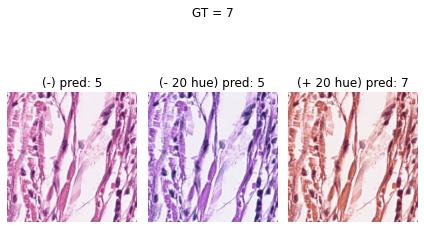

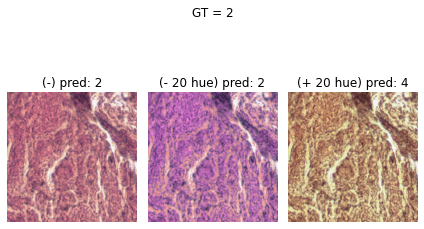

In [16]:
difference = (
    (np.array(predictions_no_hue_aug) != np.array(predictions_hue20_aug)) & 
    (np.array(predictions_hue20_aug) != np.array(predictions_huen20_aug)) 
).nonzero()

for idx in np.random.choice(difference[0], 10):
    plot_pair(
        "GT = " + str(test_vis_no_hue_dataset[idx][1]),
        [test_vis_no_hue_dataset[idx][0], test_vis_huen20_dataset[idx][0], test_vis_hue20_dataset[idx][0]], 
        [
            "(-) pred: " + str(predictions_no_hue_aug[idx]),
            "(- 20 hue) pred: " + str(predictions_huen20_aug[idx]),
            "(+ 20 hue) pred: " + str(predictions_hue20_aug[idx])
        ]
    )